In [51]:
import sklearn
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier
from scipy import sparse

In [2]:
mnist_train = pd.read_csv('datasets/mnist_train.csv')
mnist_test = pd.read_csv('datasets/mnist_test.csv')

In [3]:
mnist_train = mnist_train.dropna()
mnist_test = mnist_test.dropna()

In [4]:
mnist_train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X_train = mnist_train.drop('label', axis=1).values

X_train.shape

(60000, 784)

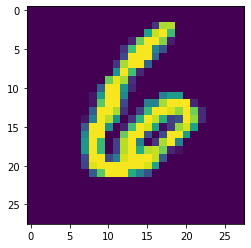

In [12]:
plt.imshow(X_train[13].reshape(28, 28))

In [13]:
Y_train = mnist_train[['label']].values

Y_train, Y_train.shape

(array([[5],
        [0],
        [4],
        ...,
        [5],
        [6],
        [8]]), (60000, 1))

In [14]:
Y_train = mnist_train[['label']].values.reshape(1, -1)

Y_train, Y_train.shape

(array([[5, 0, 4, ..., 5, 6, 8]]), (1, 60000))

In [16]:
Y_train = mnist_train[['label']].values.reshape(1, -1)[0]

Y_train, Y_train.shape

(array([5, 0, 4, ..., 5, 6, 8]), (60000,))

In [17]:
X_test = mnist_test.drop('label', axis=1).values

Y_test = mnist_test[['label']].values.reshape(1,-1)[0]

In [18]:
X_test.shape, Y_test.shape

((10000, 784), (10000,))

In [20]:
clf = SGDClassifier(loss="hinge", 
                    penalty="l2", 
                    max_iter=500)

Observe that train time for a sparse model is significantly lower than for the regular model <br>
For the sparse model we will need to sparsify the test data as well

In [21]:
%time model = clf.fit(X_train, Y_train)   

CPU times: user 2min 14s, sys: 1.45 s, total: 2min 16s
Wall time: 2min 19s


In [22]:
sparse_clf = SGDClassifier(loss="hinge", 
                           penalty="l2", 
                           max_iter=500)

In [23]:
X_train_sparse = sparse.coo_matrix(X_train)

In [24]:
X_train.shape

(60000, 784)

In [25]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [26]:
X_train_sparse.shape

(60000, 784)

In [27]:
X_train_sparse

<60000x784 sparse matrix of type '<class 'numpy.int64'>'
	with 8994156 stored elements in COOrdinate format>

#### IJV format for a sparse matrix
For each cell (i,j) in the sparse matrix which contains data, there is a 1-D array of i indices and a 1-D array of j indices and another array containing the data at (i,j)

In [28]:
X_train_sparse.row

array([    0,     0,     0, ..., 59999, 59999, 59999], dtype=int32)

In [29]:
X_train_sparse.col

array([152, 153, 154, ..., 680, 681, 682], dtype=int32)

#### What is the data at (0, 152)
The first index in X_train_sparse.row is 0. The first index in X_train_sparse.col is 152. This means that X_train[0][152] contains non-zero data. We look at X_train to get the value at that cell

In [30]:
X_train[0][152]

3

#### Data at [59999][682]

In [31]:
X_train[59999][682]

134

In [32]:
X_train_sparse.data

array([  3,  18,  18, ..., 193, 197, 134])

#### The training is quicker
It takes about half the time as the non-sparse version

In [33]:
%time sparse_model = sparse_clf.fit(X_train_sparse, Y_train).sparsify()

CPU times: user 55.3 s, sys: 245 ms, total: 55.6 s
Wall time: 55.9 s


#### Prediction time with sparse matrices
Much of the time goes into sparsifying the data

In [34]:
%time y_pred = model.predict(X_test)

CPU times: user 110 ms, sys: 154 ms, total: 263 ms
Wall time: 287 ms


In [35]:
%time X_test_sparse = sparse.coo_matrix(X_test)

CPU times: user 229 ms, sys: 42.2 ms, total: 271 ms
Wall time: 309 ms


In [36]:
%time y_pred_spar = sparse_model.predict(X_test_sparse)

CPU times: user 66.7 ms, sys: 21.7 ms, total: 88.4 ms
Wall time: 88.6 ms


#### Sparsifying can affect predictions

In [37]:
model.score(X_test, Y_test)

0.8886

In [38]:
sparse_model.score(X_test_sparse, Y_test)

0.8905

#### Getting the model size

In [39]:
import sys

In [40]:
model.coef_

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [41]:
sparse_model.coef_

<10x784 sparse matrix of type '<class 'numpy.float64'>'
	with 6707 stored elements in Compressed Sparse Row format>

#### Size of the model instance
The sys.getsizeof does not do a deep size calculation. The model instance itself only contains the pointers and it's the data being pointed to which is occupies more space.

In [42]:
sys.getsizeof(model)

56

In [43]:
sys.getsizeof(sparse_model)

56

#### Get the size of the coefficients array
Now we see the difference. The sparse model is much smaller

In [44]:
sys.getsizeof(model.coef_)

62832

In [45]:
sys.getsizeof(sparse_model.coef_)

56

#### How to work with limited memory

#### Check memory usage using the memory_profiler
A module for monitoring memory usage of a python program

In [46]:
!pip install -U memory_profiler

Requirement already up-to-date: memory_profiler in /anaconda3/lib/python3.6/site-packages (0.55.0)


### *This may not be required*
Run the next cell where memory_profiler is loaded and then the next cell where the memit magic is used. If that doesn't work, run the cell below to create the ipython profile

In [47]:
!ipython profile create

[ProfileCreate] Generating default config file: '/Users/jananiravi/.ipython/profile_default/ipython_config.py'
[ProfileCreate] Generating default config file: '/Users/jananiravi/.ipython/profile_default/ipython_kernel_config.py'


In [48]:
%load_ext memory_profiler

#### Get PID for the notebook process
This gets the PID for the current notebook. We will use retrieved PID to track memory usage from the command line

In [49]:
import os

print('PID: ', os.getpid())

PID:  43117


#### Train the model with 2MB allocated for each array 

Use the sklearn.config_context function to:
* set the size of temporary arrays for each job to 2MB
* skip validation for finiteness (with assume_finite = True) 

There are two ways to monitor memory usage. The easy one is to use the memit magic which will give the peak memory usage.

To view memory usage in real time while running the job, execute this command from a terminal window to track memory utilization for the notebook process: <br />
<i>ps -o rss= <b>pid</b> | awk '{printf "%.0f MB\n", $1 / 1024}'</i>

The value for pid here is the PID retrieved in the previous step

#### Peak memory and increment

Peak memory refers to the peak memory usage of your system (including memory usage of other processes) during the program runtime

Increment is the increment in memory usage relative to the memory usage just before the program is run (i.e. increment = peak memory - starting memory).

In [52]:
%%memit
with sklearn.config_context(assume_finite=True, 
                            working_memory=2):
    
    spar_model = clf.fit(X_train_sparse, 
                         Y_train).sparsify()
    

peak memory: 404.73 MiB, increment: 291.55 MiB


#### It is hard to track the memory utilization
The peak memory number includes all processes on your system and may not point to the amount of memory used by the process. Since the working_memory parameter only sets the size of the temporary arrays for each job and the number of jobs itself may vary each time we train our model. 

In [53]:
%%memit
with sklearn.config_context(assume_finite=True, 
                            working_memory=512):
    
    spar_model = clf.fit(X_train_sparse, 
                         Y_train).sparsify()
    

peak memory: 459.12 MiB, increment: 205.98 MiB


#### Include validation for finiteness
The assume_finite argument determines whether validation needs to be performed. The extra validation steps will slow down the entire training process

In [39]:
%%timeit
with sklearn.config_context(assume_finite=False, working_memory=512):
    
    spar_model = clf.fit(X_train_sparse, 
                         Y_train).sparsify()


CPU times: user 2min 25s, sys: 1.13 s, total: 2min 26s
Wall time: 2min 27s


In [40]:
%%timeit
with sklearn.config_context(assume_finite=True, working_memory=512):
    
    spar_model = clf.fit(X_train_sparse, 
                         Y_train).sparsify()
    

CPU times: user 2min 5s, sys: 852 ms, total: 2min 6s
Wall time: 2min 6s
